# 1. **Introduction**

---

We are from DSA3101 Group 9; Michael, Mekala, Shaomin, Yifan and Zhihao. The model we have mainly used and focussed on would be RFM Modelling. 


Each main section in this report would be highlighted with a number, and the sub-sections are prefixed with the main section's number and an additional number (eg. 1.1). Each sub-section may have further sub-sections, and can be identified with an additional alphabet. 

Our report and main code are merged together as one.

## 1.1 Import Required Packages





In [ ]:
import pandas as pd
import numpy as np
from scipy import stats 
from random import sample, seed
from math import isnan

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from mlxtend.frequent_patterns import apriori #Function for the apriori algorithm
from mlxtend.frequent_patterns import association_rules #Function for finding association rules

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.2. Import Data

### For teaching team  

**Please change the `location` variable to your desired directory to read in hackaton files.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# please change your desired directory here
location = '/content/drive/My Drive/DSA3101 Group 9/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# run the mount drive below
# put the data folder on the root directory of your google drive
df_catinfo = pd.read_csv(location + 'DSA3101_Hackathon_Categories_Information.csv')
df_hackdata= pd.read_csv(location + 'DSA3101_Hackathon_Data.csv', parse_dates=['Date'])
df_paneldemo = pd.read_excel(location + 'DSA3101_Hackathon_Panelists_Demographics.xlsx')

## 1.3. Cleaning  

### Observations & Assumptions 

Observations | Assumption | Actions
-- | -- | --
Zero volume & pack size | Error entries | removed entries  
Zero Spend rows | Customer received discounts and free gifts from shop | Include into calculation
Multiple entries on the same day from the same client | Same entry with multiple goods purchased | Grouped as a single visit  


### Definitions  

Term | Definitons  
-- | --
Effective Visits | A visit that a client spends non-trivial amount in the store
Repeated customers | A customer that has visited at least three times
RFM values | Recency, Frequency, Monetary values of each customer, large continuous values  
RFM score | R, F, M; discrete single digits

In [ ]:
# remove error entries
df_hackdata = df_hackdata[(df_hackdata['Pack Size'] != 0) & (df_hackdata['Volume'] != 0)] 

# remove unfrequent customer
df_customercount = df_hackdata['Panel ID'].value_counts()
nonrepeated_customers = df_customercount[df_customercount <= 2].index.tolist()
df_hackdata = df_hackdata[~df_hackdata['Panel ID'].isin(nonrepeated_customers)]

# 2. RFM Modelling

## 2.1. RFM Functions

### Inappropriate Definition of Recency Function

Our team orginally used the **amount of days since the most recent purchase** to indicate the recency value of each customer. This method however, did not work out well as nearly 80% of the customers have overlapping recency value and are clustered at the highest group. This defeats the purpose of customer segmentation if they are all categorised to the same group.

We need more efficient ways to rate the R criteria.

After looking at many different ways of transforming the data, our group decided on the **Geometric Mean of the days since most recent 3 purchases**.  The advantage of this method is that we are able to better differentiate two customers even if their most recent visits are equivalently recent.  

Suppose the following:  

**Customer** | **Days to most recent** | **Second recent** | **Third recent** | Arithmetic recency | Geometric recency   
-- | -- | -- | -- | -- | --
A | 1 | 9 | 11 | 7 | 4.626065  
B | 1 | 5 | 15 | 7 | 4.217163

As we can see in this above example, both client A & B had recently visited the shop yesterday and we wont be able to differentiate them apart, neither can arithmetic mean be able tell them apart; but by using geometric mean, we are able to "penalise" customers who has not visited us for a slightly longer time in the past. The lower this value, the better it is.



In [ ]:
def recency_ver2(group):
    '''
    compute the recency values by counting the number of days
    from the most recent 3 effective visits 
    '''

    spendings = group.Spend
    dates = group.Date
    date_spending = zip(dates, spendings)
    # a sorted tuple of (date, spending on date)
    date_spending = sorted(date_spending, reverse = True)

    today = pd.Timestamp.today()
    recency_value = 1
    day_count = 0

    # go through each visit, starting from the most recent visits
    for date, spend in date_spending:
       if stats.percentileofscore(spendings, spend) >= 40:
         # find a visit that is significant enough 
         day_count += 1
         recency_value *= (today - date).days  
         if day_count == 3:
           break
    
    # return the geometric mean of the top three recent purchases
    return recency_value**(1/3)

def frequency(date_series):
  return len(date_series)

def monetary(spend_series):
  return sum(spend_series) / len(spend_series)

def getRFMvalues(df, in_place = False):
    '''
    df is a dataframe that contains at least the following columns:
        * Panel ID
        * Date
        * Spend
    
    specifically, it takes in the original hackaton data, untransformed
    ''' 
    # if edit in-place
    # preferrably not to edit the original df
    df = df.copy() if in_place else df

    
    # collapse each visit into one row
    df = df.reset_index()
    # payment made on the same day by the 
    # same customer are considered as one single visit
    df_grouped = df.groupby(['Panel ID', 'Date']).agg({"Spend": sum})
    df_grouped = df_grouped.reset_index()
    df_grouped = df_grouped.groupby('Panel ID')
    
    df_rfm = df_grouped.agg({'Date': frequency,
                             'Spend': monetary})
    df_rfm = df_rfm.rename(columns = {'Date': 'Frequency', 'Spend': 'Monetary'})

    
    # df_rfm['Recency'] = df_grouped.Date.apply(recency)
    df_rfm['Recency'] = df_grouped.apply(recency_ver2)
    df_rfm = df_rfm.fillna(1000)

    return df_rfm

def getRFMscore(df, cluster = 4, in_place = False):
    '''
    Takes in a df containing the following columns:
        * recency
        * frequency
        * monetary

    return a df containing:
        * input colmns
        * R
        * F
        * M
        * RFM
    '''
    df_rfm = df.copy() if in_place else df
    
    # sort by date so that more recent customers are prioritised
    # otherwise there will be too many 
    df_rfm['R'] =  pd.qcut(df_rfm.Recency.rank(method = 'first'), 
                           q = cluster, labels = range(cluster, 0, -1)).astype('int32')
    df_rfm['F'] =  pd.qcut(df_rfm.Frequency.rank(method = 'first'), 
                           q = cluster, labels = range(1, cluster+1, 1)).astype('int32')
    df_rfm['M'] =  pd.qcut(df_rfm.Monetary.rank(method = 'first'), 
                           q = cluster, labels = range(1, cluster+1, 1)).astype('int32')
    df_rfm['RFM'] =  df_rfm.apply(lambda x: x.R*100 + x.F*10 + x.M, axis = 1)
    
    df_rfm = df_rfm['Recency Frequency Monetary R F M RFM'.split(' ')]
    
    return df_rfm

## 2.2 Clustering

### 2.2(a) Hopkins Strategy

The Hopkins statistic (Lawson and Jurs 1990) is used to assess the clustering tendency of a data set by measuring the probability that a given data set is generated by a uniform data distribution. 

The following test provides statistically evidence that there exist some potential clusters can could be uncovered:  

* $H_{0}$: the data set D is uniformly distributed (i.e., no meaningful clusters)

* $H_{1}$: the data set D is not uniformly distributed (i.e., contains meaningful clusters) Hopkin's Statistic > 0.5

Definition taken from: https://www.datanovia.com/en/lessons/assessing-clustering-tendency/

In [ ]:
df_rfm_values = getRFMvalues(df_hackdata)

In [ ]:
def hopkins(X):
    d = X.shape[1] # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
    seed(9001)
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        '''
          Compute the y-axis distance between an artificially computed point that 
          follows uniform random distribution and the nearest data point in the 
          dataset
        '''
        u_dist, _ = nbrs.kneighbors(np.random.uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).\
                                    reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1]) 
        '''
          Compute the x-axis distance between an artificially computed point that 
          follows uniform random distribution and the nearest data point in the 
          dataset
        '''
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

The Hopkin statistic calculated below is more than 95%, hence there is a very high likelihood that our null hypothesis is rejected, and the dataset contains clusters. 

In [ ]:
hopkins(df_rfm_values)

0.9709706813629051

### 2.2(b) Optimal Cluster Number via K-means Algorithm

*// Once RFM function is available and we have the RFM values available, we fill it logical to determine the range of RFM scores, for example, if K means clustering suggests that there are likely 3 clusters present, it might be statistically more significant to use a maximum value of 3 in RFM instead of using 5.

### Objective 

The purpose of doing K-means clustering is to identify what are the natural clusters that occur within the data. We will be doing K-means clustering to **identify this specific number K**. 

However, as we still want to retain the essence of RFM modelling of using percentiles and segmenting our groups based on logical thinking and understanding of our dataset, we shall not use this K value to segment our data into the specified number of clusters. 

Instead, we shall interpret this value K as the average number of natural clusters that occur across the R, F and M values. One of the main issues with our data is the skew for the Recency values in particular. 

If we were to choose any maximum number such as 3 (maximum possible RFM value: 333) or 5 to generate the percentiles, we won't be certain that the customers in each group (such as those with R score 3) are actually close enough in value to be considered as similar. We would like to reduce the variation in each group as much as we can. 

Thus, this K value shall be used as a **rough** estimate on how many parts to split our dataset into. 

In [ ]:
#df_rfm_values = getRFMvalues(df_hackdata)  
scaler = StandardScaler()
df_rfm_values_scaled = scaler.fit_transform(df_rfm_values)

def get_inertia_K(k, df = df_rfm_values_scaled):
    # defining the kmeans function with initialization as k-means++
    kmeans = KMeans(n_clusters=k, init='k-means++')
    # fitting the k means algorithm on scaled data
    kmeans.fit(df)
    return kmeans.inertia_

elbow_values = [{'k':k, 'inertia': get_inertia_K(k)} for k in range(1,9)]
elbow_values = pd.DataFrame(elbow_values)

Text(0.5, 1.0, 'K-Means Elbow Diagram')

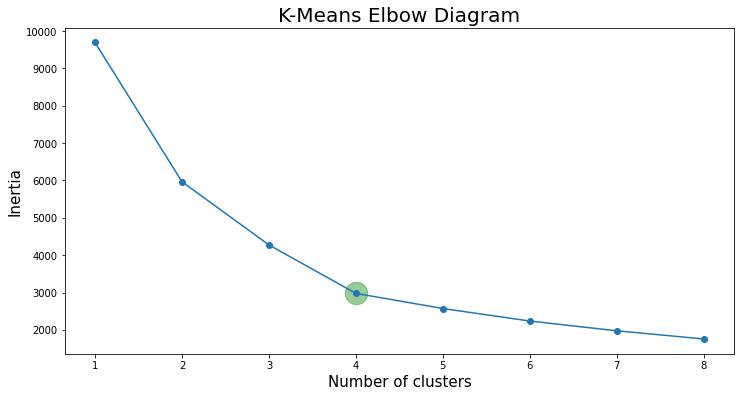

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(elbow_values.k, elbow_values.inertia, marker='o')
plt.xlabel('Number of clusters', fontsize = 15)
plt.ylabel('Inertia', fontsize = 15)
plt.scatter(4,3000, s = 500, alpha  = 0.4, color = 'green')
plt.title("K-Means Elbow Diagram", fontsize = 20)

Via the K-means result above, the elbow diagram seems to suggest a natural 4 clusters present in the data.

In [ ]:
df_rfm_scores = getRFMscore(df_rfm_values)
df_rfm_scores.head()

,Recency,Frequency,Monetary,R,F,M,RFM
Panel ID,,,,,,,
Panel 101011101,99.836399,109,35.613761,3,3,2,332.0
Panel 101016101,105.608141,71,26.416901,3,2,1,321.0
Panel 101019101,85.809657,153,46.930719,4,4,3,443.0
Panel 101024101,110.713163,153,38.972549,2,4,2,242.0
Panel 105009103,94.941275,156,30.045513,3,4,1,341.0


## 2.3. Plots for RFM distribution in Data 

**Recency**

After making the changes in how we compute our recency score, this is the new distribution that we have. It is still not a normal distribution, but the right-skew has lessened quite a bit. Most of the customers are also concentrated in the 100s region. 

count    3232.000000
mean      286.291981
std       313.818139
min         6.502957
25%        92.824040
50%       110.501741
75%       372.285277
max      1156.985883
Name: Recency, dtype: float64


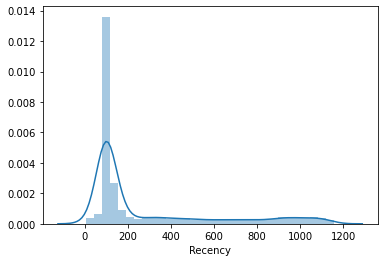

In [ ]:
print(df_rfm_scores.Recency.describe())
sns.distplot(df_rfm_scores.Recency)

**Monetary**



count    3232.000000
mean       53.818257
std        38.995668
min         5.927273
25%        31.996875
50%        45.656947
75%        63.695023
max       769.200000
Name: Monetary, dtype: float64


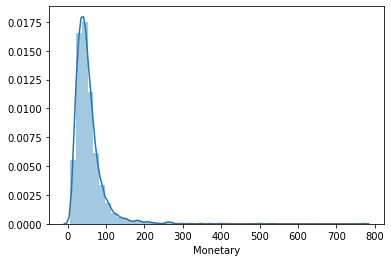

In [ ]:
print(df_rfm_scores.Monetary.describe())
sns.distplot(df_rfm_scores.Monetary)

**Frequency**

There is a dip in the middle of the plot suggesting that most customers are either frequent patrons or not, with some congregating in the middle. 

count    3232.000000
mean       76.051980
std        51.790394
min         1.000000
25%        25.000000
50%        76.000000
75%       125.000000
max       156.000000
Name: Frequency, dtype: float64


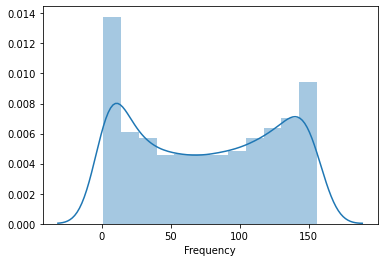

In [ ]:
print(df_rfm_scores.Frequency.describe())
sns.distplot(df_rfm_scores.Frequency)

# 3. Customer Segmentation

### Description of Segments 
Segments | Description
-- | -- 
Best Customers | Our top 10-15% of customers, with very high R,F,M scores. 
Loyalists | Our next top group of customers, who fall short of our best customers slightly.
Low-Spending Loyalists |Customers who are different from our Loyalists group only because of their less than average monetary spending.
Potential Loyalists |Customers who we hope to turn into loyalists, and are either relatively newer to the store or aren't frequent patrons, but have made high purchases.
New Customers | Customers who are exceptionally new to the store, and have made low-moderate purchases.
At-Risk (of churn) | Customers who we don't want to lose, transact on a moderate-high frequency, and spend a moderate-high amount but haven't visited recently.
Churned | Customers that have a low R, but have a moderate F or M scoring and have mostly likely switched to another store. 
Lost | Customers that have a low R,F,M scoring, i.e customers that we don't need to focus on. 

In [ ]:
# Make a copy of the rfm scores df as we are going to use it to assign each customer
# a segment.  
df_rfm_segment = df_rfm_scores.copy(deep=True)

This segment mapping below is created with the understanding that those with scores 3-4 are our customers that are higher on average, and those from 1-2 are below average.

We did not focus only on Recency, so for instance if we take a look at the Lost group vs Churned, although there are people with R -> 1 in both groups, those that are lower in other F + M, are placed in Lost and not Churned.

Initially, the segment mapping was done with regular expressions, but for clarity's sake, we have indicated exactly which RFM scores have been placed in which category, so the reader can choose to compare the definitions above and those here.


In [ ]:
# Segment Mapping
segt_map = {
    r'4[3-4][3-4]': 'Best customers',
    r'333|344|343|334|424': 'Loyalists',
    r'441|341|431|342|432|332|442':'Low-Spending Loyalists',
    r'233|243|323|324|423|331|414|244|413': 'Potential Loyalists',
    r'322|421|422|311|321|411|312|412': 'New customers',
    r'222|223|232|224|124|241|313|314|234|242|134|214': 'At-Risk',
    r'111|122|112|121|211': 'Lost',
    r'114|221|113|231|212|213|123|131|133|132': 'Churned'
}

df_rfm_segment['Segment'] = df_rfm_segment['RFM'].astype(int).map(str)
df_rfm_segment['Segment'] = df_rfm_segment['Segment'].replace(segt_map, regex=True)

df_rfm_segment.head()

,Recency,Frequency,Monetary,R,F,M,RFM,Segment
Panel ID,,,,,,,,
Panel 101011101,99.836399,109,35.613761,3,3,2,332.0,Low-Spending Loyalists
Panel 101016101,105.608141,71,26.416901,3,2,1,321.0,New customers
Panel 101019101,85.809657,153,46.930719,4,4,3,443.0,Best customers
Panel 101024101,110.713163,153,38.972549,2,4,2,242.0,At-Risk
Panel 105009103,94.941275,156,30.045513,3,4,1,341.0,Low-Spending Loyalists


In [ ]:
# Creating a df: df_rfm_plotting that would show all the different statistics 
# present across each segment. 
df_rfm_plotting=df_rfm_segment.groupby('Segment').agg(Recency=('Recency',np.median),
                                                      Frequency=('Frequency',np.median),
                                                      Monetary=('Monetary',np.median),
                                                      Count=('Segment','size'))
df_rfm_plotting['Percentage'] = df_rfm_plotting['Count']/df_rfm_plotting['Count'].sum()*100
df_rfm_plotting.sort_values(by='Percentage', ascending = False)

,Recency,Frequency,Monetary,Count,Percentage
Segment,,,,,
At-Risk,144.142508,63.0,63.918485,570,17.636139
Churned,484.966321,22.0,49.773363,528,16.336634
Low-Spending Loyalists,92.292117,132.5,34.318930,524,16.212871
Lost,778.979032,17.0,29.630556,431,13.335396
Potential Loyalists,100.581626,77.5,54.850000,398,12.314356
Loyalists,99.836399,120.0,66.005000,315,9.746287
Best customers,87.910722,141.0,61.097571,270,8.353960
New customers,94.746591,33.0,31.972581,196,6.064356


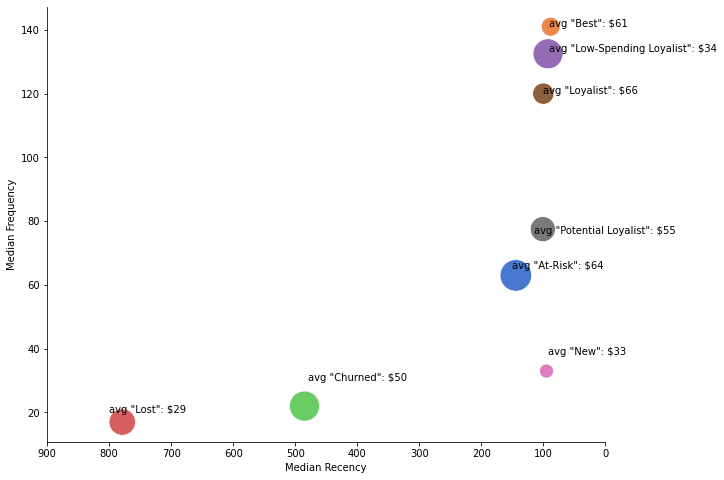

In [ ]:
# Visualization
plt.figure(figsize=(10,8))
seg_names=list(df_rfm_plotting.index.values) 
df_rfm_plotting.reset_index(level=0, inplace=True)

'''
Plot median Recency, median Frequency, and median Basket Purchase for each customer. 
Size of each point is representative of the number of customers in that category.
'''

sns.scatterplot(x='Recency',y='Frequency',hue='Segment',palette="muted", 
                hue_order=seg_names,size='Count',sizes=(200,1000),legend=False,
                data=df_rfm_plotting)
plt.xlim(900,0)
plt.text(150,65,'avg "At-Risk": $64')
plt.text(480,30,'avg "Churned": $50')
plt.text(90,133,'avg "Low-Spending Loyalist": $34')
plt.text(800,20,'avg "Lost": $29')
plt.text(115,76,'avg "Potential Loyalist": $55')
plt.text(100,120,'avg "Loyalist": $66')
plt.text(90,141,'avg "Best": $61')
plt.text(93,38,'avg "New": $33')
plt.xlabel('Median Recency')
plt.ylabel('Median Frequency')
sns.despine()

From the above section, we can see that most of our customers fall into the At-Risk, Churned and Low-Spending Loyalists.

Those that have churned, can be used in future for analysis purposes as to when they churned, and what kind of customer they were before they churned etc.

We will need to provide reccommendations for those customers that fall into the following groups:

*   Best Customers
*   Loyalists
*   Low-Spending Loyalists
*   Potential Loyalists
*   At-Risk
*   New Customers 

in order to either retain them or promote them to a new category.

These reccomendations will mainly be proposed as a means to increase our revenue and the impact of such reccomendations will be discussed in section number 5.

## 3.1. Segment Demographics

This is done to analyse if specific segmentations of our customer population tend to fall in certain categories where the proportions differ from the general customer population.

First, we will clean up the demographics table, and explore it a little.

In [ ]:
df_paneldemo.head()

,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North


In [ ]:
# We will be renaming some of the columns and editing the columns for readibility.
df_paneldemo = df_paneldemo.rename(columns={'#HH': 'Members', 'location':'Loc'})

df_paneldemo['ID'] = df_paneldemo.apply(lambda x: x["ID"].partition(" ")[2], axis=1)
df_paneldemo['Income'] = df_paneldemo.apply(lambda x: x["Income"].partition(" ")[2], axis=1)
df_paneldemo['Members'] = df_paneldemo.apply(lambda x: x["Members"].partition(" ")[0], axis=1)

# The location and the first few words in Ethnicity match, so there's no need for 
# it to be present in both areas. 
df_paneldemo['Ethnicity'] = df_paneldemo.apply(lambda x: x["Ethnicity"].split(" ")[-1], axis=1)

In [ ]:
# Types of unique values present in each column 
df_paneldemo.apply(lambda x: pd.Series(x.unique()[0:6]), axis = 0).fillna('')

,ID,BMI,Income,Ethnicity,Lifestage,Strata,Members,Loc
0,101011101,Obese,1500 - 1999,Malay,Empty Nesters,Urban,1-3,North
1,101016101,Healthy,< 1500,Chinese,Teens Aches,Rural,4,South
2,101019101,Over Weight,2000 - 2999,Others,Nesting Families,,7+,East Coast
3,101024101,Under Weight,4000 - 4999,,Teens and Toddlers,,5,Central
4,105009103,Not Available,3000 - 3999,,Matured Families,,6,
5,105015101,,>5000,,Yankys,,,


In [ ]:
# We will need to join the demographics table and the segmentation table together. 
df_rfm_segment.reset_index(inplace=True)
df_rfm_segment.rename(columns={'Panel ID': 'ID'}, inplace=True)
df_rfm_segment['ID'] = df_rfm_segment.apply(lambda x: x["ID"].partition(" ")[2], axis=1)

df_rfm_demo=df_rfm_segment.merge(df_paneldemo, on='ID', how='left')
df_rfm_demo.drop(["R", "F", "M"], axis=1, inplace=True)
df_rfm_demo.head()

,ID,Recency,Frequency,Monetary,RFM,Segment,BMI,Income,Ethnicity,Lifestage,Strata,Members,Loc
0,101011101,99.836399,109,35.613761,332.0,Low-Spending Loyalists,Obese,1500 - 1999,Malay,Empty Nesters,Urban,1-3,North
1,101016101,105.608141,71,26.416901,321.0,New customers,Healthy,1500 - 1999,Malay,Teens Aches,Urban,1-3,North
2,101019101,85.809657,153,46.930719,443.0,Best customers,Obese,< 1500,Malay,Teens Aches,Urban,4,North
3,101024101,110.713163,153,38.972549,242.0,At-Risk,Over Weight,1500 - 1999,Chinese,Nesting Families,Urban,1-3,North
4,105009103,94.941275,156,30.045513,341.0,Low-Spending Loyalists,Over Weight,< 1500,Malay,Empty Nesters,Rural,1-3,North


The following section will just be displaying percentage differences in each category across the various demographic features, please refer to the next text box with the table to show our interpretations of the overall demographics for each of the customer segments.

In [ ]:
# Function to Compare the various demographic features

def compare_features(dataset, feature):
    # Function outputs a df containing feature factors as column headers and 
    # Segment as row headers. Values are the percentages within each segment. 

    x = dataset.groupby(['Segment', feature]).size().reset_index(name='counts').\
    sort_values(ascending=False, by='counts').\
    set_index(['Segment',feature])['counts'].unstack(fill_value=0)

    x.loc[:] = x.loc[:].div(x.loc[:].sum(axis=1), axis=0).multiply(100).round()
    
    # Append row to df with population percentages for comparison purposes
    y = dataset.groupby(feature).size().reset_index(name='counts')
    y['Percentage'] = y['counts']/y['counts'].sum()*100
    x.loc['Population'] = y['Percentage'].round().tolist()
    
    return x

**BMI Analysis**

Majority of the population falls in the healthy range. This data seems to be unique to this group of customers as these proportions are not reflective of the country - Malaysia at large. 

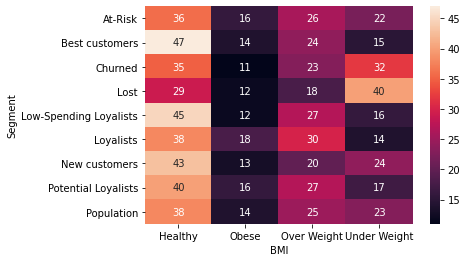

In [ ]:
sns.heatmap(compare_features(df_rfm_demo, 'BMI'), annot = True)

**Income analysis**

Most of the customers in all group appear to come from higher income level(>5K) and middle income group (2K - 3K); it is however, weird that there is a significant drop in clients in between (3K - 5K). It is abnormal that the majority of the customers are classified under two income groups that are relatively far apart.  

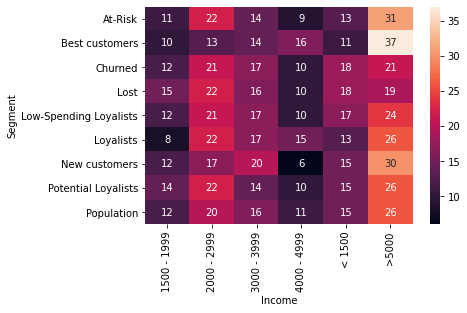

In [ ]:
sns.heatmap(compare_features(df_rfm_demo, 'Income'), annot = True)

**Lifestage**

Most of the customers are from Teens Aches and the Teens and Toddlers categories which is to be expected, as most fmailies with young or growing children would likely buy groceries (which is the main type of goods available, as can be seen from the category table).

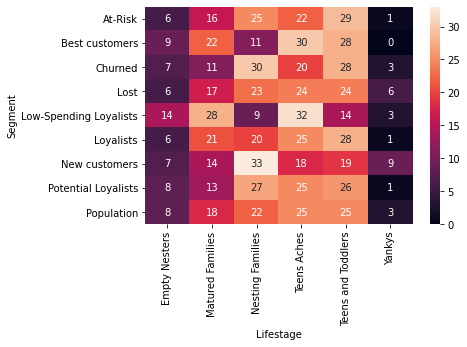

In [ ]:
sns.heatmap(compare_features(df_rfm_demo, 'Lifestage'), annot = True)

**Ethnicity**

This is also to be expected, as our dataset is from Malaysia, so there would be a higher proportion of Malay panelists. 

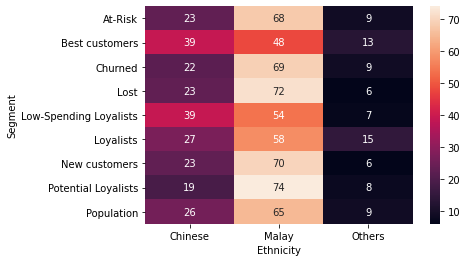

In [ ]:
sns.heatmap(compare_features(df_rfm_demo, 'Ethnicity'), annot = True)

**Family size**   

There is a strong observation that the shops are more popular among the smaller families; this could leveraged to improve the business. 

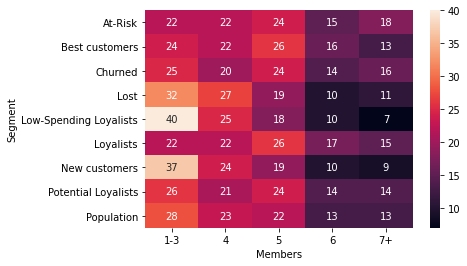

In [ ]:
sns.heatmap(compare_features(df_rfm_demo, 'Members'), annot= True)

**Location Analysis**

It is unsurprising that Central Location generally attracts most people as Central location of any region are usually the busiest place; it is also worthy to take note that the North region also possess the next significant amount of panelists.  

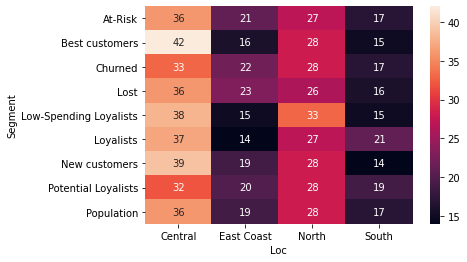

In [ ]:
sns.heatmap(compare_features(df_rfm_demo, 'Loc'), annot= True)

### 3.1(a) Demographics Analysis

As mentioned earlier, we will be focussing on the following customer segments either due to their importance in the business, or their potential to grow them into a more loyal customer: 

*   Best Customers
*   Loyalists
*Low-Spending Loyalists
*Potential Loyalists
*At-Risk
*New Customers 

The below table summarises their demographic characteristics. This is in respect to how **different** they are from the main population, and the focus is on the percentages that have increased rather than decreased. 

Best Customers

Feature | Description
-- | -- 
BMI | Proportion of individuals in Healthy category (~47% vs 38%) is higher.
Income | Proportion of individuals in >5000 category (~37% vs 26%) is higher.
Ethnicity | Proportion of individuals in Chinese category (~39% vs 26%) is higher.
Lifestage | Higher proportion of Teens Aches (30% vs 25%) and higher proportion of Matured Families (22% vs 18%).
Members | Higher proportion of 5 (26% vs 22%).
Loc | Higher proportion of Central (42% vs 36%).

Loyalists

Feature | Description
-- | -- 
BMI | - 
Income | -
Ethnicity | Lower proportion of Malay individuals (57% vs 65%) and higher propotion of Others (15% vs 9%). 
Lifestage | -
Members | Higher proportion of 5 (26% vs 22%).
Loc | -


Potential Loyalists

Feature | Description
-- | -- 
BMI | Proportion of individuals in Healthy category (~41% vs 38%) slightly higher.
Income | -
Ethnicity | Proportion of Malay individuals is signficantly higher (74% vs 65%).
Lifestage | Higher proportion of Nesting Families (27% vs 22%).
Members | -
Loc | -

Low-Spending Loyalists

Feature | Description
-- | -- 
BMI | Proportion of individuals in Healthy category (~45% vs 38%) is higher.
Income | Proportion of individuals in < 1500 category (~17% vs 15%) is slightly higher.
Ethnicity | Proportion of Chinese individuals (~39% vs 26%) is slightly higher.
Lifestage | Higher proportion of Teens Aches (32% vs 25%), and higher proportion of Matured Families (28% vs 18%).
Members | Higher proportion of 1-3 (40% vs 28%).
Loc | Higher proportion of North (33% vs 28%).

At-Risk

Feature | Description
-- | -- 
BMI | Proportion of individuals in Healthy category (~35% vs 38%) slightly lower.
Income | Proportion of individuals in >5000 category (~31% vs 26%) is higher.
Ethnicity | Higher proportion of Malay individuals (69% vs 65%) and lower proportion of Chinese individuals (22% vs 26%).
Lifestage | Higher proportion of Teens and Toddlers (20% vs 25%).
Members | Lower proportion of 1-3 (22% vs 28%), and higher proportion of 7+ (18% vs 13%). 
Loc | -

New Customers

Feature | Description
-- | -- 
BMI | Proportion of individuals in Healthy category (~45% vs 38%) slightly lower.
Income | -
Ethnicity | Higher proportion of Malay individuals (72% vs 65%) and lower proportion of Chinese individuals (18% vs 26%).
Lifestage | Higher proportion of Nesting Families (33% vs 22%).
Members | Lower proportion of 1-3 (40% vs 28%)
Loc | -

## 3.2. Average Basket Size

The average basket size can give us clues as to how many items an individual from each customer segment may buy at each shop visit. 

We can choose to leverage on this point to increase sales of items.

We calculate this by counting the number of items in each visit and taking the average by customer ID.

In [1]:
df_average_basket_size = df_hackdata[["Panel ID", "Category","Date"]].\
                          groupby(['Panel ID', 'Date']).\
                          count().\
                          reset_index().\
                          groupby(['Panel ID']).\
                          mean().\
                          reset_index().\
                          rename(columns = {"Category":"Average Basket Size",'Panel ID': 'ID'})
df_average_basket_size['ID'] = df_average_basket_size.apply(lambda x: x["ID"].partition(" ")[2], axis=1)
df_average_basket_size.head()

NameError: ignored

In [ ]:
df_rfm_demo = df_rfm_demo.merge(df_average_basket_size, on = "ID")
df_basket_segment = df_rfm_demo[["Segment","Average Basket Size"]].groupby(["Segment"]).mean()
df_basket_segment


,Average Basket Size
Segment,
At-Risk,5.793411
Best customers,6.977529
Churned,5.227258
Lost,3.495081
Low-Spending Loyalists,3.917218
Loyalists,6.645050
New customers,3.601530
Potential Loyalists,5.879123


## 3.3 Variance in Purchasing



**How to calculate unit price:**

The general idea to get spending per unit is to divide Spend by purchasing Volume. However, there are some invalid values existing in the data: Pack Size and Volume are recorded as 0, which is impossible in the real life. We suppose the actual data here is missing, so it can only be recorded as zero, therefore this situation should be special treated during calculation. If volume is zero, we divide Spend by the number of Pack Size.If the number of both volume and pack Size are missing, spend will be returned.

In [ ]:
def per_spend(size,vol,spend):
    if size==0 and vol==0:
        return spend
    elif vol==0:
        return spend/size
    else:
        return spend/vol

In [ ]:
spending_df = df_hackdata.copy()
spending_df["per spend"]=spending_df.apply(lambda row: per_spend(row['Pack Size'], row["Volume"],row["Spend"]),axis=1)
spending_df["Panel ID"]=spending_df["Panel ID"].apply(lambda x:x.split(" ")[-1])
spending_df

,Panel ID,Date,Category,Pack Size,Volume,Spend,per spend
0,101011101,2017-07-02,CSD,1,1.5,1.5,1.000000
1,101011101,2017-07-02,Soy Milk,1,1.0,2.8,2.800000
2,101011101,2017-07-02,Cooking Sauces,1,0.3,3.2,10.666667
3,101011101,2017-07-02,Coconut Milk,2,0.4,5.3,13.250000
4,101011101,2017-07-02,Chocolate,1,0.2,6.6,33.000000
...,...,...,...,...,...,...,...
1318018,801912801,2020-02-09,Sugar,3,3.0,8.6,2.866667
1318019,801912801,2020-02-23,MSG,1,0.1,2.2,22.000000
1318020,801912801,2020-02-23,Eggs,1,30.0,8.4,0.280000
1318021,801912801,2020-02-23,Ice Cream,1,1.5,8.0,5.333333


**Grouping data by ID and Category**


 So our goal is to recognise if there is any relationship between the different features of customer and their purchasing habits.Firstly, we need to know for each customer, how many times and what category of good they have bought from store.In the data frame below,it shows the average unit money of each customer spending on each categories. For example, for customer 101011101, he bought 17 times biscuits and the mean of unit price he spent on biscuits is 17.84 per volumn. 
 

In [ ]:
id_cate_df=spending_df.groupby(["Panel ID","Category"])
id_cate_df.size()

Panel ID   Category   
101011101  Biscuits       16
           Bouilon         4
           Butter          4
           CSD             6
           Cake            3
                          ..
801912801  Ice Cream       1
           Liquid Milk     1
           MSG             2
           Rice            2
           Sugar           1
Length: 95536, dtype: int64

In [ ]:
mean_grp=id_cate_df.mean()
df_regrp=mean_grp.reset_index()
df_regrp

,Panel ID,Category,Pack Size,Volume,Spend,per spend
0,101011101,Biscuits,1.750000,0.443750,6.481250,18.782738
1,101011101,Bouilon,1.000000,0.100000,2.875000,28.750000
2,101011101,Butter,2.500000,0.650000,11.350000,17.918750
3,101011101,CSD,9.166667,13.833333,15.800000,1.565146
4,101011101,Cake,1.000000,0.333333,5.233333,18.000000
...,...,...,...,...,...,...
95531,801912801,Ice Cream,1.000000,1.500000,8.000000,5.333333
95532,801912801,Liquid Milk,1.000000,1.000000,7.300000,7.300000
95533,801912801,MSG,1.000000,0.100000,2.200000,22.000000
95534,801912801,Rice,1.000000,10.000000,26.750000,2.675000


**Standard price dataset**


  Comparing the average money that each customer spends on with the given average price of each category. For example, if customer A spends much more than average on Beer, it means he is willing to buy premium Beer. If all our target customers have the same buying trends, store can replenish more goods customers prefering to buy in a higher price. This can increase revenue in some extent. 

In [ ]:
standard_price=df_catinfo.copy()

In [ ]:
def compare_with_standard(df):
    cate=df["Category"]
    std=standard_price[standard_price["Category"]==cate]["Price per Volume"]
    if float(df["per spend"])>float(std):
        return 0 #0 stands for spending more than average
    else:
        return 1 
std=standard_price[standard_price["Category"]=="CSD"]["Price per Volume"]
float(df_regrp[0:1]["per spend"])>float(std)
df_regrp["comparision"]=df_regrp.apply(lambda row: compare_with_standard(row),axis=1)
df_regrp.head()

,Panel ID,Category,Pack Size,Volume,Spend,per spend,comparision
0,101011101,Biscuits,1.750000,0.443750,6.481250,18.782738,0
1,101011101,Bouilon,1.000000,0.100000,2.875000,28.750000,1
2,101011101,Butter,2.500000,0.650000,11.350000,17.918750,1
3,101011101,CSD,9.166667,13.833333,15.800000,1.565146,1
4,101011101,Cake,1.000000,0.333333,5.233333,18.000000,1


**Create a new to store unique id and category list**

For column cheap, it contains all categories that customer likes to buy in less than average price, which probably be cheap brands or purchasing it only with discount.Same idea for expensive.

In [ ]:
def shopping_willing(row,x):
    id=str(int(row["Panel ID"]))
    shopping_df=df_regrp[(df_regrp["comparision"]==x)&(df_regrp["Panel ID"]==id)]
    shoppinglist=", ".join(shopping_df["Category"].unique().tolist())
    return shoppinglist

In [ ]:
id=df_regrp["Panel ID"].unique().tolist()
df4=pd.DataFrame({"Panel ID":id})

In [ ]:
df4["expensive"]=df4.apply(lambda row: shopping_willing(row,0),axis=1)
df4["cheap"]=df4.apply(lambda row: shopping_willing(row,1),axis=1)
df4.head()

,Panel ID,expensive,cheap
0,101011101,"Biscuits, Canned Product, Cereals, Cheese, Cho...","Bouilon, Butter, CSD, Cake, Cereal Beverage, C..."
1,101016101,"Cereals, Choc/Nut Spread, Cordials, Instant No...","Biscuits, Bouilon, Coffee, Condensed/Evap Milk..."
2,101019101,"Biscuits, CSD, Canned Product, Cereals, Cordia...","Belacan, Cake, Chocolate, Coconut Milk, Coffee..."
3,101024101,"Biscuits, Cereal Beverage, Cooking Oils, Flour...","Bouilon, CSD, Cake, Canned Product, Cereals, C..."
4,105009103,"Bouilon, Canned Product, Cordials, Drinking Wa...","Biscuits, Cereal Beverage, Coffee, Confectione..."


Then joining this dataframe with the cleaned data with different features of customers.

In [ ]:
df_rfm_demo_2 = df_rfm_demo.copy()
df_rfm_demo_2 = df_rfm_demo_2.rename(columns={'ID':'Panel ID'})
df_join=pd.concat([df_rfm_demo,df4],axis=1,join="inner")
df_join.head()

,ID,Recency,Frequency,Monetary,RFM,Segment,BMI,Income,Ethnicity,Lifestage,Strata,Members,Loc,Average Basket Size,Panel ID,expensive,cheap
0,101011101,99.836399,109,35.613761,332.0,Low-Spending Loyalists,Obese,1500 - 1999,Malay,Empty Nesters,Urban,1-3,North,3.596330,101011101,"Biscuits, Canned Product, Cereals, Cheese, Cho...","Bouilon, Butter, CSD, Cake, Cereal Beverage, C..."
1,101016101,105.608141,71,26.416901,321.0,New customers,Healthy,1500 - 1999,Malay,Teens Aches,Urban,1-3,North,4.366197,101016101,"Cereals, Choc/Nut Spread, Cordials, Instant No...","Biscuits, Bouilon, Coffee, Condensed/Evap Milk..."
2,101019101,85.809657,153,46.930719,443.0,Best customers,Obese,< 1500,Malay,Teens Aches,Urban,4,North,10.568627,101019101,"Biscuits, CSD, Canned Product, Cereals, Cordia...","Belacan, Cake, Chocolate, Coconut Milk, Coffee..."
3,101024101,110.713163,153,38.972549,242.0,At-Risk,Over Weight,1500 - 1999,Chinese,Nesting Families,Urban,1-3,North,6.418301,101024101,"Biscuits, Cereal Beverage, Cooking Oils, Flour...","Bouilon, CSD, Cake, Canned Product, Cereals, C..."
4,105009103,94.941275,156,30.045513,341.0,Low-Spending Loyalists,Over Weight,< 1500,Malay,Empty Nesters,Rural,1-3,North,7.884615,105009103,"Bouilon, Canned Product, Cordials, Drinking Wa...","Biscuits, Cereal Beverage, Coffee, Confectione..."


**Relationship between feature and customer preferences**

1. Listing all features existing in original demographics data

In [ ]:
features={}
col_names=df_join.columns.values.tolist()
col_names.remove("Panel ID")
col_names.remove("ID")
col_names.remove("Average Basket Size")
col_names.remove("Recency")
col_names.remove("Frequency")
col_names.remove("Monetary")
col_names.remove("RFM")
col_names.remove("cheap")
col_names.remove("expensive")

for col in col_names:
    features[col]=df_join[col].unique().tolist()

2. Listing all existing products categories


In [ ]:
features

{'BMI': ['Obese', 'Healthy', 'Over Weight', 'Under Weight'],
 'Ethnicity': ['Malay', 'Chinese', 'Others'],
 'Income': ['1500 - 1999',
  '< 1500',
  '2000 - 2999',
  '4000 - 4999',
  '3000 - 3999',
  '>5000'],
 'Lifestage': ['Empty Nesters',
  'Teens Aches',
  'Nesting Families',
  'Teens and Toddlers',
  'Matured Families',
  'Yankys'],
 'Loc': ['North', 'South', 'Central', 'East Coast'],
 'Members': ['1-3', '4', '7+', '5', '6'],
 'Segment': ['Low-Spending Loyalists',
  'New customers',
  'Best customers',
  'At-Risk',
  'Churned',
  'Lost',
  'Potential Loyalists',
  'Loyalists'],
 'Strata': ['Urban', 'Rural']}

In [ ]:
categories = standard_price["Category"].unique().tolist()

  For each features (f in features), there are many types (a in f), such as there are 4 types of regions under the feature Loc. For each type, we sum up the number of customer (total) belonging to this type.Then for these customers, we can have the number of customer(temp) who likes to spend more money on each category. 
    The category percentage is calculated by the number of customer in the type of feature who likes to spend more money on the current category, devided by the total number of customer belonging to that type. This percentage can show the preference of the type towards different categories. If the number is small, it means that few customers under that type of feature show no interests to this products. Therefore store can replenish less on that to save expenses and tend to category which is popular among customers.

In [ ]:
features_summary={}
num_summary={}
for f in features.keys():
    for a in features[f]:
        a_list=[]
        num_list=[]
        total=len(df_join[df_join[f]==a])
        for cate in categories:
            temp_df=df_join[df_join[f]==a]
            temp=temp_df["expensive"].str.contains(cate).value_counts().to_dict()
            if True in temp.keys():
                val=temp[True]
            else:
                val=0
            a_list.append(val)
            num_list.append(val/total)
        features_summary[a]= a_list
        num_summary[a]=num_list


Create a feature data frame to store the number of customer in each features  that prefer to spend more in the category.

In [ ]:
features_df=pd.DataFrame(features_summary)
features_df=features_df.T
features_df.columns=categories
features_df.head()

,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,CSD,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,MSG,Peanut Butter,Rice,RTD Coffee,RTD Tea,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts
Low-Spending Loyalists,16,41,0,13,327,184,196,56,273,179,131,125,32,58,103,225,256,323,46,329,333,238,20,158,132,191,295,6,284,236,192,37,40,146,346,58,181,72,161,280,285,183,11,21,100,135,237,68,113,215,19,187,188,130,147,3,290,294,374,0,143,156
New customers,8,10,0,2,84,47,39,17,60,25,35,29,1,14,16,56,47,86,7,77,99,42,3,36,24,35,102,4,61,53,36,6,11,22,83,7,26,12,21,72,44,24,6,5,23,27,62,13,19,43,5,31,45,23,29,0,52,60,93,1,29,38
Best customers,19,40,2,10,212,123,141,51,157,121,120,98,35,60,90,143,167,197,41,186,195,148,14,111,75,136,146,9,186,161,143,48,40,123,216,49,115,74,106,164,178,115,23,42,74,103,153,52,101,165,21,118,134,100,108,8,186,189,188,9,101,101
At-Risk,32,34,1,12,364,207,185,72,284,184,148,113,19,62,121,239,269,358,45,322,327,242,14,131,115,148,273,8,238,242,175,49,36,147,343,45,124,56,130,262,248,138,29,79,93,141,237,44,109,217,21,150,201,92,153,3,224,315,366,2,116,150
Churned,20,22,2,5,301,141,101,41,218,100,93,62,8,35,70,168,191,289,31,261,270,164,9,102,96,128,261,5,144,204,127,21,22,74,246,26,86,32,101,214,148,82,15,45,72,74,161,45,71,147,3,100,161,66,90,1,209,217,320,0,77,83


Create a percentage data frame to store the percentage of customer in each features  that prefer to spend more in the category.

In [ ]:
percentage_df=pd.DataFrame(num_summary)
percentage_df=percentage_df.T
percentage_df.columns=categories
percentage_df.head(8)

,Baby Cereal,Beer,Belacan,Bird Nest,Biscuits,Bouilon,Butter,Cake,Canned Product,Cereal Beverage,Cereals,Cheese,Chicken Essence,Choc/Nut Spread,Chocolate,Coconut Milk,Coffee,Condensed/Evap Milk,Confectionery,Cooking Oils,Cooking Sauces,Cordials,Creamer,CSD,Cultured Milk,Drinking Water,Eggs,Energy Drinks,Flour,Frozen Food,Fruit/Veg Juices,Ghee,Honey,Ice Cream,Instant Noodles,Instant Soup,Isotonic Drinks,Jam,Kaya,Liquid Milk,Margarine,Milk Powder-Adult,Milk Powder-Infant,Milk Powder-Kids,MSG,Peanut Butter,Rice,RTD Coffee,RTD Tea,Salad Dressing,Savoury Spread,Seasoning Powder,Snack,Soy Milk,Spagetti,Spirits,Sugar,Tea,Tonic Food Drink,Wine,Yoghurt Drink,Yoghurts
Low-Spending Loyalists,0.030534,0.078244,0.000000,0.024809,0.624046,0.351145,0.374046,0.106870,0.520992,0.341603,0.250000,0.238550,0.061069,0.110687,0.196565,0.429389,0.488550,0.616412,0.087786,0.627863,0.635496,0.454198,0.038168,0.301527,0.251908,0.364504,0.562977,0.011450,0.541985,0.450382,0.366412,0.070611,0.076336,0.278626,0.660305,0.110687,0.345420,0.137405,0.307252,0.534351,0.543893,0.349237,0.020992,0.040076,0.190840,0.257634,0.452290,0.129771,0.215649,0.410305,0.036260,0.356870,0.358779,0.248092,0.280534,0.005725,0.553435,0.561069,0.713740,0.000000,0.272901,0.297710
New customers,0.040816,0.051020,0.000000,0.010204,0.428571,0.239796,0.198980,0.086735,0.306122,0.127551,0.178571,0.147959,0.005102,0.071429,0.081633,0.285714,0.239796,0.438776,0.035714,0.392857,0.505102,0.214286,0.015306,0.183673,0.122449,0.178571,0.520408,0.020408,0.311224,0.270408,0.183673,0.030612,0.056122,0.112245,0.423469,0.035714,0.132653,0.061224,0.107143,0.367347,0.224490,0.122449,0.030612,0.025510,0.117347,0.137755,0.316327,0.066327,0.096939,0.219388,0.025510,0.158163,0.229592,0.117347,0.147959,0.000000,0.265306,0.306122,0.474490,0.005102,0.147959,0.193878
Best customers,0.070370,0.148148,0.007407,0.037037,0.785185,0.455556,0.522222,0.188889,0.581481,0.448148,0.444444,0.362963,0.129630,0.222222,0.333333,0.529630,0.618519,0.729630,0.151852,0.688889,0.722222,0.548148,0.051852,0.411111,0.277778,0.503704,0.540741,0.033333,0.688889,0.596296,0.529630,0.177778,0.148148,0.455556,0.800000,0.181481,0.425926,0.274074,0.392593,0.607407,0.659259,0.425926,0.085185,0.155556,0.274074,0.381481,0.566667,0.192593,0.374074,0.611111,0.077778,0.437037,0.496296,0.370370,0.400000,0.029630,0.688889,0.700000,0.696296,0.033333,0.374074,0.374074
At-Risk,0.056140,0.059649,0.001754,0.021053,0.638596,0.363158,0.324561,0.126316,0.498246,0.322807,0.259649,0.198246,0.033333,0.108772,0.212281,0.419298,0.471930,0.628070,0.078947,0.564912,0.573684,0.424561,0.024561,0.229825,0.201754,0.259649,0.478947,0.014035,0.417544,0.424561,0.307018,0.085965,0.063158,0.257895,0.601754,0.078947,0.217544,0.098246,0.228070,0.459649,0.435088,0.242105,0.050877,0.138596,0.163158,0.247368,0.415789,0.077193,0.191228,0.380702,0.036842,0.263158,0.352632,0.161404,0.268421,0.005263,0.392982,0.552632,0.642105,0.003509,0.203509,0.263158
Churned,0.037879,0.041667,0.003788,0.009470,0.570076,0.267045,0.191288,0.077652,0.412879,0.189394,0.176136,0.117424,0.015152,0.066288,0.132576,0.318182,0.361742,0.547348,0.058712,0.494318,0.511364,0.310606,0.017045,0.193182,0.181818,0.242424,0.494318,0.009470,0.272727,0.386364,0.240530,0.039773,0.041667,0.140152,0.465909,0.049242,0.162879,0.060606,0.191288,0.405303,0.280303,0.155303,0.028409,0.085227,0.136364,0.140152,0.304924,0.085227,0.134470,0.278409,0.005682,0.189394,0.304924,0.125000,0.170455,0.001894,0.395833,0.410985,0.606061,0.000000,0.145833,0.157197
Lost,0.023202,0.016241,0.000000,0.000000,0.482599,0.167053,0.118329,0.051044,0.308585,0.136891,0.120650,0.104408,0.004640,0.032483,0.095128,0.227378,0.262181,0.459397,0.034803,0.373550,0.466357,0.192575,0.004640,0.111369,0.109049,0.143852,0.401392,0.002320,0.155452,0.259861,0.148492,0.027842,0.025522,0.111369,0.366589,0.020882,0.104408,0.032483,0.125290,0.357309,0.229698,0.106729,0.013921,0.020882,0.071926,0.081206,0.257541,0.037123,0.062645,0.153132,0.011601,0.155452,0.2

In [ ]:
percentage_df.sort_values(by="Best customers",axis=1).head(8)

,Belacan,Spirits,Energy Drinks,Wine,Bird Nest,Creamer,Baby Cereal,Savoury Spread,Milk Powder-Infant,Chicken Essence,Beer,Honey,Confectionery,Milk Powder-Kids,Ghee,Instant Soup,Cake,RTD Coffee,Choc/Nut Spread,MSG,Jam,Cultured Milk,Chocolate,Cheese,Soy Milk,Yoghurt Drink,RTD Tea,Yoghurts,Peanut Butter,Kaya,Spagetti,CSD,Isotonic Drinks,Milk Powder-Adult,Seasoning Powder,Cereals,Cereal Beverage,Bouilon,Ice Cream,Snack,Drinking Water,Butter,Coconut Milk,Fruit/Veg Juices,Eggs,Cordials,Rice,Canned Product,Frozen Food,Liquid Milk,Salad Dressing,Coffee,Margarine,Sugar,Flour,Cooking Oils,Tonic Food Drink,Tea,Cooking Sauces,Condensed/Evap Milk,Biscuits,Instant Noodles
Low-Spending Loyalists,0.000000,0.005725,0.011450,0.000000,0.024809,0.038168,0.030534,0.036260,0.020992,0.061069,0.078244,0.076336,0.087786,0.040076,0.070611,0.110687,0.106870,0.129771,0.110687,0.190840,0.137405,0.251908,0.196565,0.238550,0.248092,0.272901,0.215649,0.297710,0.257634,0.307252,0.280534,0.301527,0.345420,0.349237,0.356870,0.250000,0.341603,0.351145,0.278626,0.358779,0.364504,0.374046,0.429389,0.366412,0.562977,0.454198,0.452290,0.520992,0.450382,0.534351,0.410305,0.488550,0.543893,0.553435,0.541985,0.627863,0.713740,0.561069,0.635496,0.616412,0.624046,0.660305
New customers,0.000000,0.000000,0.020408,0.005102,0.010204,0.015306,0.040816,0.025510,0.030612,0.005102,0.051020,0.056122,0.035714,0.025510,0.030612,0.035714,0.086735,0.066327,0.071429,0.117347,0.061224,0.122449,0.081633,0.147959,0.117347,0.147959,0.096939,0.193878,0.137755,0.107143,0.147959,0.183673,0.132653,0.122449,0.158163,0.178571,0.127551,0.239796,0.112245,0.229592,0.178571,0.198980,0.285714,0.183673,0.520408,0.214286,0.316327,0.306122,0.270408,0.367347,0.219388,0.239796,0.224490,0.265306,0.311224,0.392857,0.474490,0.306122,0.505102,0.438776,0.428571,0.423469
Best customers,0.007407,0.029630,0.033333,0.033333,0.037037,0.051852,0.070370,0.077778,0.085185,0.129630,0.148148,0.148148,0.151852,0.155556,0.177778,0.181481,0.188889,0.192593,0.222222,0.274074,0.274074,0.277778,0.333333,0.362963,0.370370,0.374074,0.374074,0.374074,0.381481,0.392593,0.400000,0.411111,0.425926,0.425926,0.437037,0.444444,0.448148,0.455556,0.455556,0.496296,0.503704,0.522222,0.529630,0.529630,0.540741,0.548148,0.566667,0.581481,0.596296,0.607407,0.611111,0.618519,0.659259,0.688889,0.688889,0.688889,0.696296,0.700000,0.722222,0.729630,0.785185,0.800000
At-Risk,0.001754,0.005263,0.014035,0.003509,0.021053,0.024561,0.056140,0.036842,0.050877,0.033333,0.059649,0.063158,0.078947,0.138596,0.085965,0.078947,0.126316,0.077193,0.108772,0.163158,0.098246,0.201754,0.212281,0.198246,0.161404,0.203509,0.191228,0.263158,0.247368,0.228070,0.268421,0.229825,0.217544,0.242105,0.263158,0.259649,0.322807,0.363158,0.257895,0.352632,0.259649,0.324561,0.419298,0.307018,0.478947,0.424561,0.415789,0.498246,0.424561,0.459649,0.380702,0.471930,0.435088,0.392982,0.417544,0.564912,0.642105,0.552632,0.573684,0.628070,0.638596,0.601754
Churned,0.003788,0.001894,0.009470,0.000000,0.009470,0.017045,0.037879,0.005682,0.028409,0.015152,0.041667,0.041667,0.058712,0.085227,0.039773,0.049242,0.077652,0.085227,0.066288,0.136364,0.060606,0.181818,0.132576,0.117424,0.125000,0.145833,0.134470,0.157197,0.140152,0.191288,0.170455,0.193182,0.162879,0.155303,0.189394,0.176136,0.189394,0.267045,0.140152,0.304924,0.242424,0.191288,0.318182,0.240530,0.494318,0.310606,0.304924,0.412879,0.386364,0.405303,0.278409,0.361742,0.280303,0.395833,0.272727,0.494318,0.606061,0.410985,0.511364,0.547348,0.570076,0.465909
Lost,0.000000,0.000000,0.002320,0.000000,0.000000,0.004640,0.023202,0.011601,0.013921,0.004640,0.016241,0.025522,0.034803,0.020882,0.027842,0.020882,0.051044,0.037123,0.032483,0.071926,0.032483,0.109049,0.095128,0.104408,0.095128,0.116009,0.062645,0.118329,0.081206,0.125290,0.122970,0.111369,0.104408,0.106729,0.155452,0.120650,0.136891,0.167053,0.111369,0.248260,0.143852,0.118329,0.227378,0.148492,0.401392,0.192575,0.257541,0.308585,0.259861,0.357309,0.153132,0.262181,0.2

# 4. Recomendations

## 4.1 Loyalty Program

Loyalty Program will target groups blue and green with the goals of increasing customer satisfaction, loyalty in brand, and interest in up and coming products.

Group Blue has a higher proportion of Teen Aches and a relatively smaller basket size of about 3-4 items, which is below average. The loyalty program could encourage cross selling to increase number of items bought per basket, which would lead to an increase in monetary value of these customers. Since "Low Spending Loyalists" have the second highest average frequency scores, a slight increase in average amount spent per visit could dramatically increase overall revenue from this group. 

Group Green would benefit from rewards, or benefits that the loyalty program could give. The loyalty program for Group Green could focus on showing that these shoppers are valued to enourage them to continue their positive spending habits. Loyalty points could  be given out to reward shoppers for their purchases and allow them to redeem gifts or products, enticing them to stay loyal to the store. Shoppers from Group Green have a larger family size and thus rewards could be more family oriented. Additionally, Group Green may benefit from bundling of goods that are bought in tandem frequently.  

## 4.2 Bundling
Using Market Basket Analysis, we are able to identify associative rules for multiple items. Items that have a strong association with each other can be packaged into bundles to be promoted. This will increase consumer loyalty due to added convenience and also provide opportunities to upsell.

In [ ]:
main = df_hackdata.copy() #copy the main df
new = main['Panel ID'].str.split(" ", n = 1, expand = True) #Split the Panel ID into ID only 
main['ID'] = new[1]
big_data = main.merge(df_rfm_demo, on = 'ID') #merge with the demographics files
spend = big_data[big_data["Segment"].isin(['Low-Spending Loyalists', 'New customers'])] #customers we are looking for 
l =spend[['Category', 'ID', 'Date']] #select the categories, ID and Dates to get the baskets
l.loc[:,'a'] = 1 
l2 =l.drop_duplicates() 
basket_set = l2.groupby(["Date","ID", "Category"])["a"].sum().unstack().fillna(0).reset_index()
basket_set.drop(["Date", 'ID'], axis = 1 , inplace = True) #obtain the baskets
frequent_itemsets = apriori(basket_set,min_support = 0.01, use_colnames = True) 
rules = association_rules(frequent_itemsets, metric="confidence",min_threshold = 0.2) #find the association rules
rules.drop(['leverage','conviction'],axis=1,inplace=True)
rules.sort_values('lift', ascending = False).head() #sort the rules

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
537,"(Cooking Oils, Flour)","(Condensed/Evap Milk, Sugar)",0.039548,0.058975,0.010985,0.277759,4.709732
539,"(Flour, Condensed/Evap Milk)","(Cooking Oils, Sugar)",0.035075,0.068125,0.010985,0.313178,4.597115
561,"(Cooking Sauces, Sugar)","(Condensed/Evap Milk, Rice)",0.052056,0.046237,0.010672,0.205014,4.434001
559,"(Condensed/Evap Milk, Rice)","(Cooking Sauces, Sugar)",0.046237,0.052056,0.010672,0.230814,4.434001
546,"(Condensed/Evap Milk, Rice)","(Cooking Oils, Sugar)",0.046237,0.068125,0.013486,0.291679,4.281528


## 4.3 Purchase Coupons

The is an observation that there is a significant cluster of customers who usally spend less than \$50 on each visit. The number of people who spend more than \$50 drops significantly afterwards. If suppose we provide a coupon or discount for any purchase more than \$50 on a single visit, we will be able to target a significant number of customers and "nudge" them into higher spending brackets.

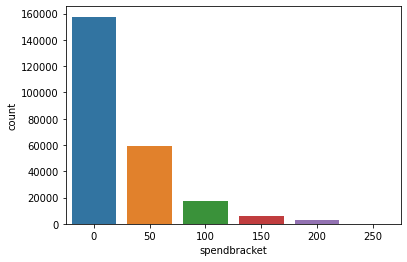

In [ ]:
df_SpendPerVisit = df_hackdata.groupby(['Panel ID', 'Date']).agg({'Spend': sum}).reset_index()
# only look at the logical spenders
df_SpendPerVisit = df_SpendPerVisit[df_SpendPerVisit.Spend <= 250]
# put them into spending bracket
df_SpendPerVisit['spendbracket'] = df_SpendPerVisit.Spend.apply(lambda x: int(x)//50 * 50)
sns.countplot(df_SpendPerVisit.spendbracket)

# 5. Impact of Recommendations

This section will describe how impactful we predict our recommendations will be. This is based on the assumption that our recommendations will succeed in their motives. Our team chose to quantify the impact by calculating the potential revenue increase expected in the next quarterly financial report, assuming all other factors being equal.  

The groups that we are targetting, which are mainly the Blue and Orange groups will be promoted as such: 

*   (Orange) Low Spending Loyalists --> (Green) Loyalist
*   (Orange) Potential Loyalists --> (Green) Loyalist
*   (Blue) At-Risk --> Potential Loyalist (Orange)
*   (Blue) New Customers --> Potential Loyalist (Orange)


In [ ]:
df_hackdata.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6


In [ ]:
# Keep transactions that are of the most recent business quarter from the max Date available in data
df_latest_qtr = df_hackdata[df_hackdata.Date >='2020-03-15']
df_latest_qtr = df_latest_qtr.rename(columns = {'Panel ID': 'ID'})
df_latest_qtr['ID'] = df_latest_qtr.apply(lambda x: x["ID"].partition(" ")[2], axis=1)

df_latest_qtr = df_latest_qtr.merge(df_rfm_demo, on = 'ID', how='left')
df_latest_qtr = df_latest_qtr.groupby(['ID','Segment']).agg(Spend=('Spend',sum)).\
   reset_index().\
   groupby('Segment').agg(Spend=('Spend',sum), Count=('ID', 'count')).reset_index()

# Spend here refers to the total amount of money spent by each customer on average over a period of 90 days.
df_latest_qtr['Spend/Customer']=df_latest_qtr['Spend']/df_latest_qtr['Count']
df_latest_qtr = df_latest_qtr.sort_values(by='Spend', ascending=False).reset_index(drop=True)
df_latest_qtr

,Segment,Spend,Count,Spend/Customer
0,Best customers,292158.7,270,1082.069259
1,Loyalists,281306.6,315,893.036825
2,Low-Spending Loyalists,257323.0,524,491.074427
3,Potential Loyalists,156427.4,298,524.924161
4,At-Risk,136238.1,353,385.943626
5,New customers,42962.1,116,370.362931
6,Churned,18564.7,119,156.005882
7,Lost,1244.8,13,95.753846


In [ ]:
# Calculate how much the increase is is for each type of segment promotion
a = (df_latest_qtr['Spend/Customer'].values[1] - df_latest_qtr['Spend/Customer'].values[3])*df_latest_qtr['Count'].values[3]
b = (df_latest_qtr['Spend/Customer'].values[1] - df_latest_qtr['Spend/Customer'].values[2])*df_latest_qtr['Count'].values[2]
c = (df_latest_qtr['Spend/Customer'].values[3] - df_latest_qtr['Spend/Customer'].values[4])*df_latest_qtr['Count'].values[4]
d = (df_latest_qtr['Spend/Customer'].values[3] - df_latest_qtr['Spend/Customer'].values[5])*df_latest_qtr['Count'].values[5]

total = a+b+c+d # 386870 increase in revenue

percent_inc = (total/df_latest_qtr['Spend'].sum())*100
percent_inc # 32.6% increase 

32.65105451458169

## 5.2 Coupons  

The following assumes the fact that we give a:
* \$5 discount for any purchase exceeding \$50.


Under such an assumption, we assume that the customers behave this way:

Original Spending | New Spending | Effect on Revenue  
-- | -- | --
less than 25 | no change | no change 
between 25 - 50 | spend 50 each visit | 45 for each visit  
above 50 | no change | minus 5 on their original spending

In [ ]:
# revenue in the most recent quarter
# from April 2020 - June 2020
quarter_start = pd.to_datetime("01/04/2020", format="%d/%m/%Y")
# recent quarter
df_rq = df_hackdata[df_hackdata.Date >= quarter_start]
df_SpendPerVisit = df_rq.groupby(['Panel ID', 'Date']).agg({'Spend': sum}).reset_index()
# only look at the logical spenders
df_SpendPerVisit = df_SpendPerVisit[df_SpendPerVisit.Spend <= 250]
# put them into spending bracket
df_SpendPerVisit['spendbracket'] = df_SpendPerVisit.Spend.apply(lambda x: int(x)//10 * 10)

def cust_behav(ori_spend):
  if ori_spend < 25:
    return ori_spend
  elif ori_spend <= 50:
    return 45
  else:
    return ori_spend - 5
    
df_SpendPerVisit['newspend'] = df_SpendPerVisit.Spend.apply(cust_behav)

The following is the expected percentage we expect to gain from a simple coupon strategy, we could achieve better results if we are able to give more discounts at each tier.  

In [ ]:
improve = (df_SpendPerVisit.newspend.sum() - df_SpendPerVisit.Spend.sum())/df_SpendPerVisit.Spend.sum()
"{:.2f}%".format(improve*100)

'0.59%'